In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/Torch/chap05/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Torch/chap05


In [ ]:
# !unzip catanddog.zip -d catanddog/

In [ ]:
data_path = 'catanddog/train/'
    
transform = transforms.Compose([transforms.Resize([256, 256]), 
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=32, 
                                           num_workers=8, 
                                           shuffle=True)

print(f"len(train_dataset): {len(train_dataset)}")

385


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


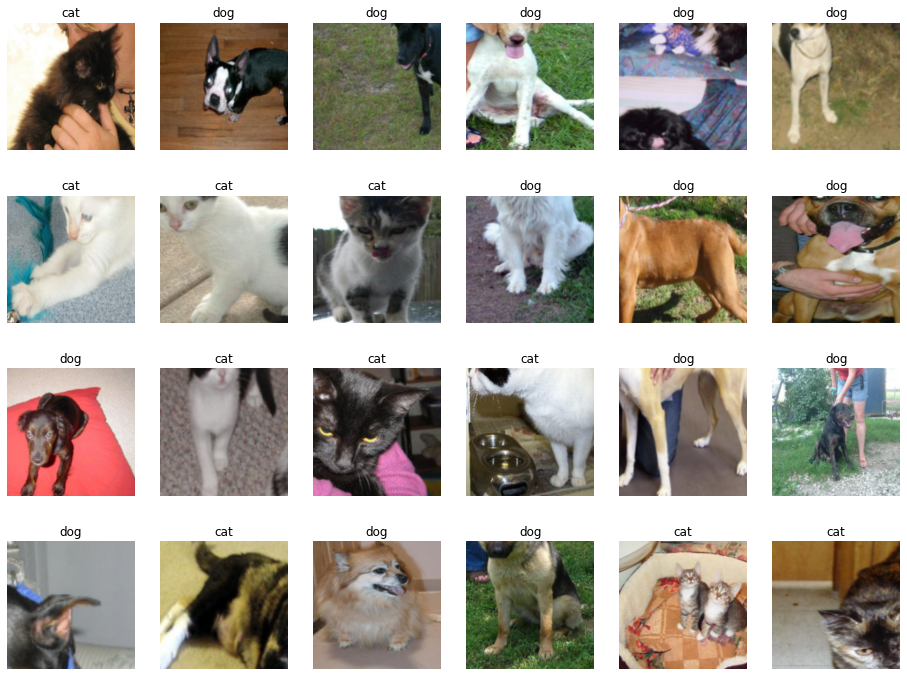

In [ ]:
import numpy as np

samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16, 24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [ ]:
resnet18.fc = nn.Linear(512, 2)

In [ ]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0343, -0.0057,  0.0122,  ..., -0.0362, -0.0423, -0.0051],
        [-0.0221,  0.0127,  0.0174,  ..., -0.0297, -0.0228, -0.0038]])
fc.bias tensor([ 0.0028, -0.0042])


In [ ]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [ ]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.6153 Acc: 0.6727

Epoch 1/12
----------
Loss: 0.4462 Acc: 0.7896

Epoch 2/12
----------
Loss: 0.3429 Acc: 0.8571

Epoch 3/12
----------
Loss: 0.3344 Acc: 0.8519

Epoch 4/12
----------
Loss: 0.2626 Acc: 0.9013

Epoch 5/12
----------
Loss: 0.2279 Acc: 0.9221

Epoch 6/12
----------
Loss: 0.2022 Acc: 0.9273

Epoch 7/12
----------
Loss: 0.1983 Acc: 0.9429

Epoch 8/12
----------
Loss: 0.2196 Acc: 0.9039

Epoch 9/12
----------
Loss: 0.2246 Acc: 0.8909

Epoch 10/12
----------
Loss: 0.1854 Acc: 0.9351

Epoch 11/12
----------
Loss: 0.2360 Acc: 0.8935

Epoch 12/12
----------
Loss: 0.1843 Acc: 0.9273

Training complete in 7m 57s
Best Acc: 0.942857


In [ ]:
test_path = 'catanddog/test/'

transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(root=test_path, 
                                                transform=transform )
                                                
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=32, 
                                          num_workers=1, 
                                          shuffle=True)

print(len(test_dataset))

98


In [ ]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [ ]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 0.7041

Loading model catanddog/01.pth
Acc: 0.8878

Loading model catanddog/02.pth
Acc: 0.9184

Loading model catanddog/03.pth
Acc: 0.9184

Loading model catanddog/04.pth
Acc: 0.9490

Loading model catanddog/05.pth
Acc: 0.9286

Loading model catanddog/06.pth
Acc: 0.9286

Loading model catanddog/07.pth
Acc: 0.9286

Loading model catanddog/08.pth
Acc: 0.9388

Loading model catanddog/09.pth
Acc: 0.9286

Loading model catanddog/10.pth
Acc: 0.9490

Loading model catanddog/11.pth
Acc: 0.9490

Loading model catanddog/12.pth
Acc: 0.9286

Validation complete in 2m 37s
Best Acc: 0.948980


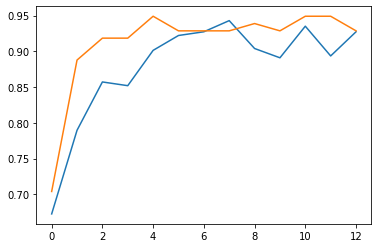

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

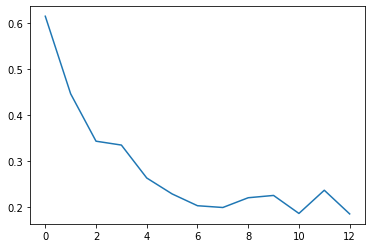

In [ ]:
plt.plot(train_loss_hist)
plt.show()

In [ ]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

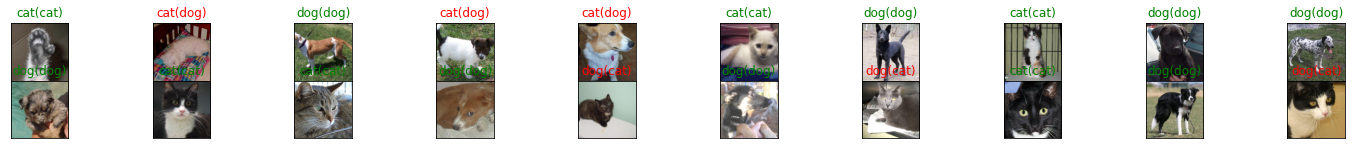

In [ ]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  
images,labels=dataiter.next()  
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),
                                 str(classes[labels[idx].item()])),
                 color=("green" if preds[idx]==labels[idx] else "red"))  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
plt.show()  